In [2]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, precision_recall_curve
from xgboost import XGBClassifier
import joblib

# Load dataset using Dask
df = dd.read_csv('datasets/paysim.csv')

# Select relevant columns
df = df[['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']]
df_pd = df.compute()

# Feature Engineering
df_pd["delta_balance_org"] = df_pd["oldbalanceOrg"] - df_pd["newbalanceOrig"]
df_pd["delta_balance_dest"] = df_pd["newbalanceDest"] - df_pd["oldbalanceDest"]
df_pd["balance_ratio"] = df_pd["amount"] / (df_pd["oldbalanceOrg"] + 1)
df_pd["same_sender_receiver"] = (df_pd["oldbalanceOrg"] == df_pd["oldbalanceDest"]).astype(int)

# Features and labels
X = df_pd.drop('isFraud', axis=1)
y = df_pd['isFraud']

# Preprocessing
cat_cols = ['type']
num_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
            'delta_balance_org', 'delta_balance_dest', 'balance_ratio', 'same_sender_receiver']

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', 'passthrough', num_cols)
])

# Model pipeline
model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=10,
        tree_method="hist",
        eval_metric="aucpr"
    ))
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train
model_pipeline.fit(X_train, y_train)

# Evaluate
y_pred = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))

# # Find best threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_threshold = thresholds[np.argmax(f1_scores)]

print("Best threshold:", best_threshold)
print("Best F1 score:", f1_scores[np.argmax(f1_scores)])

# Save model and threshold
joblib.dump(model_pipeline, "stripe_fraud_model.pkl")
joblib.dump(best_threshold, "optimal_threshold.pkl")

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predictions
y_pred = model_pipeline.predict(X_test)

# Scores
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print("📊 Model Performance:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")



              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.76      0.99      0.86      1643

    accuracy                           1.00   1272524
   macro avg       0.88      1.00      0.93   1272524
weighted avg       1.00      1.00      1.00   1272524

Best threshold: 0.8641462
Best F1 score: 0.8987152669038111
📊 Model Performance:
Accuracy : 0.9996
Precision: 0.7644
Recall   : 0.9915
F1 Score : 0.8633


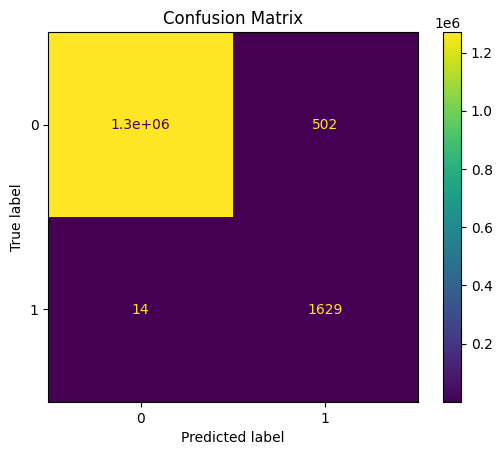

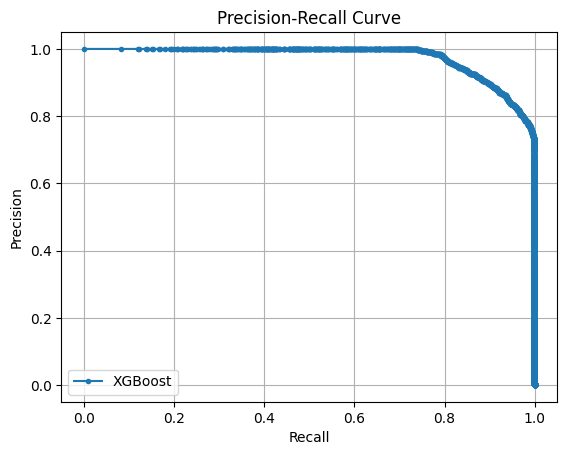

In [102]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve

# Confusion Matrix
y_pred = model_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Precision-Recall Curve
y_proba = model_pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure()
plt.plot(recall, precision, marker='.', label='XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()


#### KIRTANS CODE


In [44]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, confusion_matrix
from xgboost import XGBClassifier
import joblib
from imblearn.over_sampling import RandomOverSampler
import plotly.graph_objects as go
import plotly.offline as pyo

# Load dataset using Dask
df = dd.read_csv('datasets/synthetic_transactions.csv')

# Drop unnecessary columns if they exist
columns_to_drop = ['Transaction_ID', 'Currency']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

# Compute to convert to pandas DataFrame
df_pd = df.compute()

# Extract time-based features from Date
df_pd['Date'] = pd.to_datetime(df_pd['Date'], errors='coerce')
df_pd['Transaction_Hour'] = df_pd['Date'].dt.hour
df_pd['Transaction_Weekday'] = df_pd['Date'].dt.weekday
df_pd['Is_Weekend'] = df_pd['Transaction_Weekday'].isin([5, 6]).astype(int)

# Drop unused or excluded columns
df_pd = df_pd.drop(columns=['Date', 'Risk_Type', 'Incident_Severity', 'Error_Code'], errors='ignore')

# Target and features
y = df_pd['Risk_Incident']
X = df_pd.drop(columns=['Risk_Incident'])

# Frequency encode high-cardinality columns
for col in ['Account_Number', 'Counterparty', 'User_ID', 'IP_Region']:
    if col in X.columns:
        freq = X[col].value_counts().to_dict()
        X[col] = X[col].map(freq)

# Define categorical and numerical columns
cat_cols = ['Transaction_Type', 'Category', 'Payment_Method']
num_cols = [col for col in X.columns if col not in cat_cols]

# Fill missing values in categorical columns
for col in cat_cols:
    if col in X.columns:
        X[col] = X[col].fillna("missing")

# Fill missing values in numerical columns
for col in num_cols:
    if col in X.columns:
        X[col] = X[col].fillna(X[col].median())

# Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols)
])

# Encode features
X_encoded = preprocessor.fit_transform(X)

# Balance the dataset using RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_encoded, y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, stratify=y_resampled, test_size=0.2, random_state=42)

# Hyperparameter tuning
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

clf = RandomizedSearchCV(
    XGBClassifier(
        scale_pos_weight=1,
        tree_method="hist",
        eval_metric="aucpr",
        random_state=42
    ),
    param_distributions=param_dist,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Train
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_threshold = thresholds[np.argmax(f1_scores)]

# Save model and threshold
joblib.dump(clf.best_estimator_, "stripe_fraud_model.pkl")
joblib.dump(best_threshold, "optimal_threshold.pkl")

# Final scores
print("📊 XGBoost Model Performance:")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred, zero_division=0):.4f}")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Not Fraud', 'Fraud']  # same for both axes

print("\n📊 Confusion Matrix:")
print(cm)

# Plotly heatmap
fig = go.Figure(data=go.Heatmap(
    z=cm,
    x=labels,  # Predicted labels
    y=labels,  # Actual labels
    hoverongaps=False,
    colorscale='Blues',
    showscale=True,
    text=cm,
    texttemplate="%{text}",
    hovertemplate="Actual: %{y}<br>Predicted: %{x}<br>Count: %{z}<extra></extra>"
))

fig.update_layout(
    title='Confusion Matrix (XGBoost)',
    xaxis=dict(title='Predicted Label', tickmode='array', tickvals=[0, 1], ticktext=labels),
    yaxis=dict(title='Actual Label', tickmode='array', tickvals=[0, 1], ticktext=labels),
    template='plotly_white'
)

# Render in browser
pyo.plot(fig, filename='confusion_matrix_plotly.html', auto_open=True)


# Compute precision-recall values
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Plot PR curve
fig_pr = go.Figure()
fig_pr.add_trace(go.Scatter(
    x=recall,
    y=precision,
    mode='lines+markers',
    name='Precision-Recall',
    hovertemplate='Recall: %{x:.2f}<br>Precision: %{y:.2f}<extra></extra>'
))

fig_pr.update_layout(
    title='Precision-Recall Curve',
    xaxis_title='Recall',
    yaxis_title='Precision',
    template='plotly_white'
)

pyo.plot(fig_pr, filename='precision_recall_curve.html', auto_open=True)


thresholds = np.linspace(0.0, 1.0, 101)
recall_list = []
precision_list = []
f1_list = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    precision_t = precision_score(y_test, y_pred_t, zero_division=0)
    recall_t = recall_score(y_test, y_pred_t, zero_division=0)
    f1_t = f1_score(y_test, y_pred_t, zero_division=0)
    precision_list.append(precision_t)
    recall_list.append(recall_t)
    f1_list.append(f1_t)

# Create DataFrame
tradeoff_df = pd.DataFrame({
    "Threshold": thresholds,
    "Precision": precision_list,
    "Recall": recall_list,
    "F1 Score": f1_list
})

# Plotly line plot for all three metrics
fig_tradeoff = go.Figure()
fig_tradeoff.add_trace(go.Scatter(x=thresholds, y=precision_list, name='Precision', mode='lines+markers'))
fig_tradeoff.add_trace(go.Scatter(x=thresholds, y=recall_list, name='Recall', mode='lines+markers'))
fig_tradeoff.add_trace(go.Scatter(x=thresholds, y=f1_list, name='F1 Score', mode='lines+markers'))

fig_tradeoff.update_layout(
    title='Precision / Recall / F1 vs Threshold',
    xaxis_title='Threshold',
    yaxis_title='Score',
    template='plotly_white'
)

pyo.plot(fig_tradeoff, filename='precision_recall_tradeoff.html', auto_open=True)

# Optional: print top 10 rows
print(tradeoff_df.sort_values(by='F1 Score', ascending=False).head(10))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
📊 XGBoost Model Performance:
Accuracy : 0.9491
Precision: 0.9206
Recall   : 0.9830
F1 Score : 0.9508

📊 Confusion Matrix:
[[1566  145]
 [  29 1681]]
    Threshold  Precision    Recall  F1 Score
58       0.58   0.958668  0.976608  0.967555
59       0.59   0.960208  0.973684  0.966899
57       0.57   0.954934  0.978947  0.966792
60       0.60   0.963912  0.968421  0.966161
62       0.62   0.970484  0.961404  0.965922
61       0.61   0.966608  0.964912  0.965759
56       0.56   0.948980  0.978947  0.963731
63       0.63   0.972586  0.954386  0.963400
65       0.65   0.977670  0.947368  0.962281
64       0.64   0.975316  0.947368  0.961139
